In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/Dataset/UNSW-NB15/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Dataset/UNSW-NB15/UNSW_NB15_testing-set.csv')

data = pd.concat([train_df, test_df], ignore_index=True)

data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Identify the target variable
categorical_target = 'attack_cat'
binary_target = 'label'

# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to the target variable
if categorical_target in data.columns:
    data[categorical_target] = label_encoder.fit_transform(data[categorical_target])

# Apply label encoding to each categorical feature
for col in data.select_dtypes(include=['object']).columns:
    data[col] = label_encoder.fit_transform(data[col])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply normalization to numerical features excluding the target variables
features_to_scale = data.columns.difference([categorical_target, binary_target])
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, LSTM, MultiHeadAttention, GlobalAveragePooling1D



# Assume 'binary_target' and 'multi_class_target' are the names of the target variables
X = data.drop(columns=['label', 'attack_cat'])
y_binary = data['label']
y_multi_class = data['attack_cat']

In [ ]:
# Train-test split
X_train, X_test, y_train_binary, y_test_binary, y_train_multi_class, y_test_multi_class = train_test_split(
    X, y_binary, y_multi_class, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for CNN 1D input
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)


CNN+LSTM


In [ ]:
# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# LSTM for sequence modeling
x = LSTM(50, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)

# Shared Dense layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
modelLSTM_P = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

In [ ]:
# Compile the model
modelLSTM_P.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)


In [ ]:
# Train the model
modelLSTM_P.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=5, batch_size=32, validation_split=0.2
)

Epoch 1/5
5154/5154 [==============================] - 102s 19ms/step - loss: 1.0813 - binary_output_loss: 0.2420 - multi_class_output_loss: 0.8393 - binary_output_accuracy: 0.8845 - multi_class_output_accuracy: 0.6955 - val_loss: 0.8431 - val_binary_output_loss: 0.1720 - val_multi_class_output_loss: 0.6712 - val_binary_output_accuracy: 0.9128 - val_multi_class_output_accuracy: 0.7492
Epoch 2/5
5154/5154 [==============================] - 95s 19ms/step - loss: 0.8369 - binary_output_loss: 0.1703 - multi_class_output_loss: 0.6666 - binary_output_accuracy: 0.9157 - multi_class_output_accuracy: 0.7537 - val_loss: 0.7430 - val_binary_output_loss: 0.1457 - val_multi_class_output_loss: 0.5973 - val_binary_output_accuracy: 0.9289 - val_multi_class_output_accuracy: 0.7749
Epoch 3/5
5154/5154 [==============================] - 92s 18ms/step - loss: 0.7771 - binary_output_loss: 0.1540 - multi_class_output_loss: 0.6231 - binary_output_accuracy: 0.9243 - multi_class_output_accuracy: 0.7688 - val_l

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = modelLSTM_P.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}


1611/1611 [==============================] - 14s 9ms/step
Binary Classification:
Accuracy: 0.9489667216454837
Precision: 0.9595266990291262
Recall: 0.9606342263531985
F1 Score: 0.960080143286482
Confusion Matrix:
[[17279  1334]
 [ 1296 31626]]

Multi-Class Classification:
Accuracy: 0.8002910643252159
Precision: 0.7583135642881194
Recall: 0.8002910643252159
F1 Score: 0.7656570400360679
Confusion Matrix:
[[    1     0     0   434     4     0    70    10     0     0]
 [    0     0     0   420     6     0     5    37     0     0]
 [    0     0     0  3034    58     0    57   143     0     0]
 [    0     0     1  8280   240     4   191   364     0     0]
 [    0     0     0   767  2305     3  1421   335     0     0]
 [    0     0     0   213    39 11220    22    43     0     0]
 [    0     0     0   165   589     0 17674   185     0     0]
 [    0     0     1   932    80     0    76  1763     0     0]
 [    0     0     0    21    25     0    25   238     0     0]
 [    0     0     0    31  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


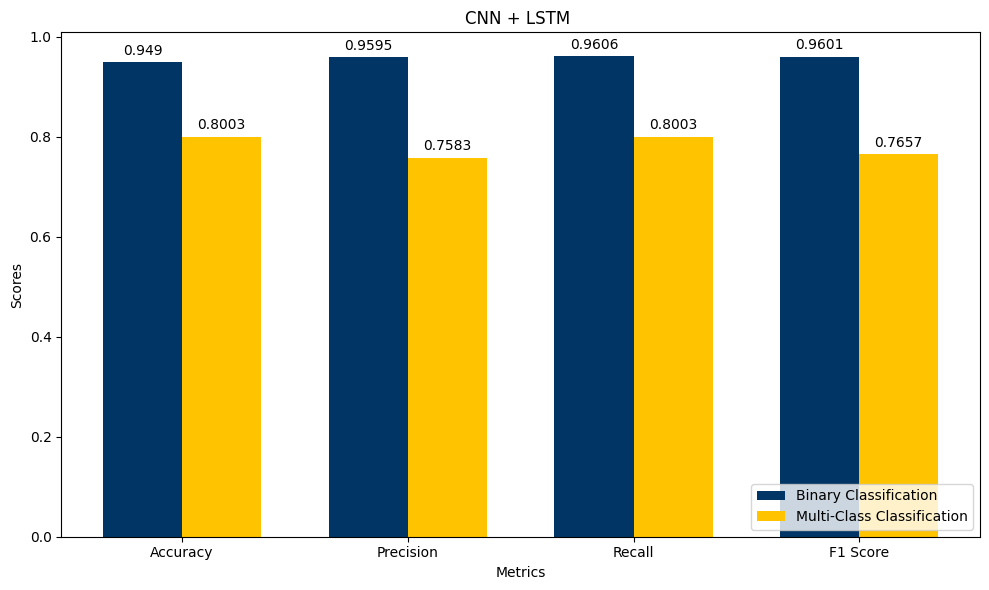

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + LSTM ')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

CNN+BiLSTM

In [ ]:
# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# LSTM for sequence modeling
x = LSTM(50, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)

# Shared Dense layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
modelBiLSTM_P = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])


In [ ]:
# Compile the model
modelBiLSTM_P.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)

In [ ]:
# Train the model
modelBiLSTM_P.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=5, batch_size=32, validation_split=0.2
)


Epoch 1/5
5154/5154 [==============================] - 135s 26ms/step - loss: 1.0681 - binary_output_loss: 0.2351 - multi_class_output_loss: 0.8330 - binary_output_accuracy: 0.8877 - multi_class_output_accuracy: 0.6941 - val_loss: 0.8239 - val_binary_output_loss: 0.1636 - val_multi_class_output_loss: 0.6603 - val_binary_output_accuracy: 0.9187 - val_multi_class_output_accuracy: 0.7459
Epoch 2/5
5154/5154 [==============================] - 135s 26ms/step - loss: 0.8351 - binary_output_loss: 0.1684 - multi_class_output_loss: 0.6667 - binary_output_accuracy: 0.9157 - multi_class_output_accuracy: 0.7541 - val_loss: 0.7608 - val_binary_output_loss: 0.1487 - val_multi_class_output_loss: 0.6120 - val_binary_output_accuracy: 0.9262 - val_multi_class_output_accuracy: 0.7741
Epoch 3/5
5154/5154 [==============================] - 121s 23ms/step - loss: 0.7770 - binary_output_loss: 0.1548 - multi_class_output_loss: 0.6221 - binary_output_accuracy: 0.9237 - multi_class_output_accuracy: 0.7708 - val

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = modelBiLSTM_P.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}


1611/1611 [==============================] - 9s 5ms/step
Binary Classification:
Accuracy: 0.9431066265644708
Precision: 0.9548625856943518
Recall: 0.9561387522021748
F1 Score: 0.9555002428363283
Confusion Matrix:
[[17125  1488]
 [ 1444 31478]]

Multi-Class Classification:
Accuracy: 0.7996701270980887
Precision: 0.7459501420087767
Recall: 0.7996701270980887
F1 Score: 0.764543906379383
Confusion Matrix:
[[    0     0     0   443     1     0    70     5     0     0]
 [    0     0     0   428     5     0     2    33     0     0]
 [    0     0     0  3063    76     2    43   108     0     0]
 [    0     0     0  8307   309     4   269   191     0     0]
 [    0     0     0   737  2289     0  1582   223     0     0]
 [    0     0     0   213    63 11224    21    16     0     0]
 [    0     0     0   173   683     0 17567   190     0     0]
 [    0     0     0   911    47     0    70  1824     0     0]
 [    0     0     0    69    52     0    20   168     0     0]
 [    0     0     0    29   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


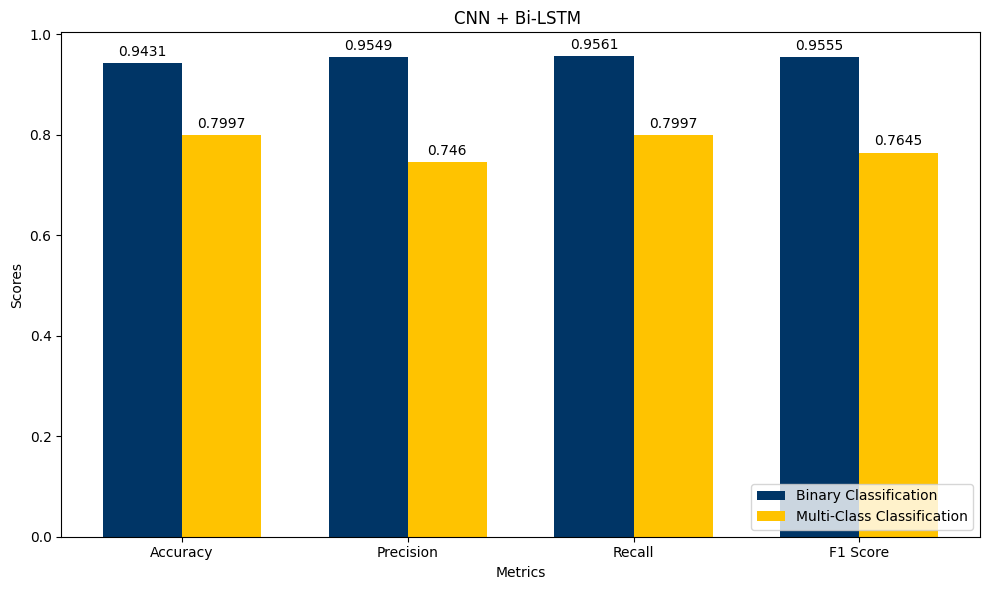

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + Bi-LSTM ')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

CNN+GRU

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GRU, GlobalAveragePooling1D

In [ ]:
# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# GRU for sequence modeling
x = GRU(50, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)

# Shared Dense layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
modelGRU_P = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

In [ ]:
# Compile the model
modelGRU_P.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)

In [ ]:
# Train the model
modelGRU_P.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=5, batch_size=32, validation_split=0.2
)


Epoch 1/5
5154/5154 [==============================] - 120s 23ms/step - loss: 1.0749 - binary_output_loss: 0.2357 - multi_class_output_loss: 0.8392 - binary_output_accuracy: 0.8872 - multi_class_output_accuracy: 0.6941 - val_loss: 0.8062 - val_binary_output_loss: 0.1524 - val_multi_class_output_loss: 0.6538 - val_binary_output_accuracy: 0.9294 - val_multi_class_output_accuracy: 0.7628
Epoch 2/5
5154/5154 [==============================] - 92s 18ms/step - loss: 0.8185 - binary_output_loss: 0.1606 - multi_class_output_loss: 0.6579 - binary_output_accuracy: 0.9237 - multi_class_output_accuracy: 0.7594 - val_loss: 0.7082 - val_binary_output_loss: 0.1306 - val_multi_class_output_loss: 0.5776 - val_binary_output_accuracy: 0.9431 - val_multi_class_output_accuracy: 0.7904
Epoch 3/5
5154/5154 [==============================] - 102s 20ms/step - loss: 0.7418 - binary_output_loss: 0.1398 - multi_class_output_loss: 0.6019 - binary_output_accuracy: 0.9375 - multi_class_output_accuracy: 0.7837 - val_

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = modelGRU_P.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}


1611/1611 [==============================] - 15s 9ms/step
Binary Classification:
Accuracy: 0.955777626855535
Precision: 0.9699414164340705
Recall: 0.9605431018771642
F1 Score: 0.9652193819152995
Confusion Matrix:
[[17633   980]
 [ 1299 31623]]

Multi-Class Classification:
Accuracy: 0.8152905792180072
Precision: 0.841687041294569
Recall: 0.8152905792180072
F1 Score: 0.7808306049636827
Confusion Matrix:
[[    2     0     0   421     3     0    84     9     0     0]
 [    0     0     0   427     7     0    10    24     0     0]
 [    0     0     1  3057    69     1    66    98     0     0]
 [    0     0     0  8321   325     2   240   192     0     0]
 [    0     0     0   723  2718     0  1229   161     0     0]
 [    0     0     0   227    51 11218    25    16     0     0]
 [    0     0     0   113   456     0 17961    83     0     0]
 [    0     0     0   891    52     0   118  1791     0     0]
 [    0     0     0    33    77     0    34   161     4     0]
 [    0     0     0    30   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


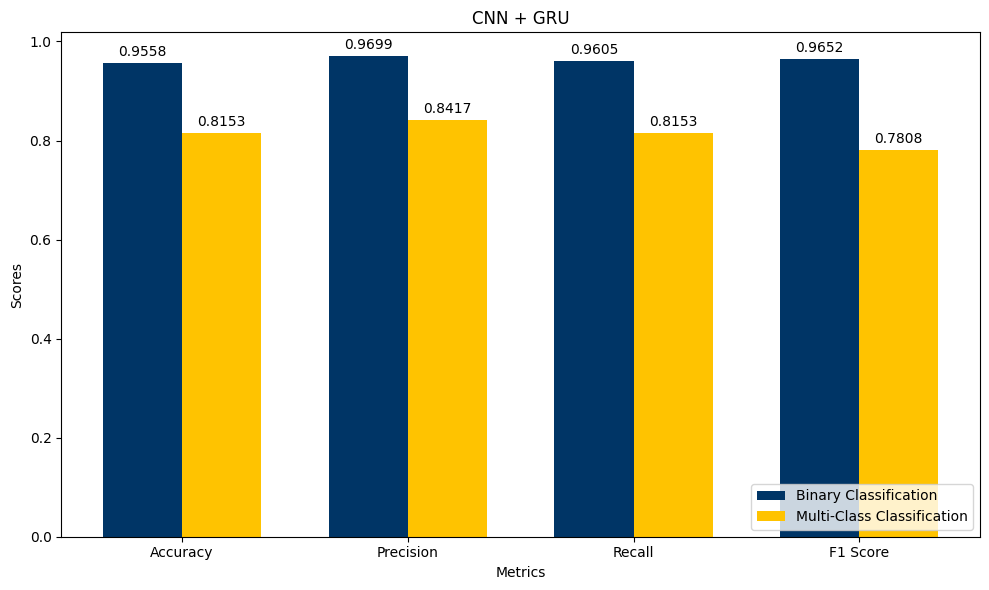

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + GRU')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

CNN+Bi_GRU

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, GRU, GlobalAveragePooling1D

In [ ]:
# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# Bidirectional GRU for sequence modeling
x = Bidirectional(GRU(50, return_sequences=True))(x)
x = GlobalAveragePooling1D()(x)

# Shared Dense layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
modelBiGRU_P = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

In [ ]:
# Compile the model
modelBiGRU_P.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)

In [ ]:
# Train the model
modelBiGRU_P.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=5, batch_size=32, validation_split=0.2
)

Epoch 1/5
5154/5154 [==============================] - 147s 27ms/step - loss: 1.0538 - binary_output_loss: 0.2351 - multi_class_output_loss: 0.8187 - binary_output_accuracy: 0.8928 - multi_class_output_accuracy: 0.7020 - val_loss: 0.7423 - val_binary_output_loss: 0.1412 - val_multi_class_output_loss: 0.6011 - val_binary_output_accuracy: 0.9373 - val_multi_class_output_accuracy: 0.7767
Epoch 2/5
5154/5154 [==============================] - 141s 27ms/step - loss: 0.7699 - binary_output_loss: 0.1472 - multi_class_output_loss: 0.6227 - binary_output_accuracy: 0.9363 - multi_class_output_accuracy: 0.7735 - val_loss: 0.6783 - val_binary_output_loss: 0.1204 - val_multi_class_output_loss: 0.5580 - val_binary_output_accuracy: 0.9478 - val_multi_class_output_accuracy: 0.7926
Epoch 3/5
5154/5154 [==============================] - 141s 27ms/step - loss: 0.7034 - binary_output_loss: 0.1266 - multi_class_output_loss: 0.5768 - binary_output_accuracy: 0.9462 - multi_class_output_accuracy: 0.7915 - val

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = modelBiGRU_P.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}


1611/1611 [==============================] - 13s 8ms/step
Binary Classification:
Accuracy: 0.9599495488502959
Precision: 0.970855712890625
Recall: 0.9663143186926675
F1 Score: 0.9685796924950525
Confusion Matrix:
[[17658   955]
 [ 1109 31813]]

Multi-Class Classification:
Accuracy: 0.8160279421752207
Precision: 0.7910761943127016
Recall: 0.8160279421752207
F1 Score: 0.7826712447244888
Confusion Matrix:
[[   18     0     0   405     9     0    84     3     0     0]
 [    0     0     0   411    27     0     6    24     0     0]
 [    0     0     1  3041   100     2    58    90     0     0]
 [    4     0     0  8251   402     1   223   199     0     0]
 [    2     0     0   691  2979     0  1064    95     0     0]
 [    0     0     1   209    69 11220    10    28     0     0]
 [    0     0     1   117   478     0 17951    66     0     0]
 [    0     0     0   880   215     0   123  1634     0     0]
 [    0     0     0    60    49     0    27   173     0     0]
 [    0     0     0    31  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


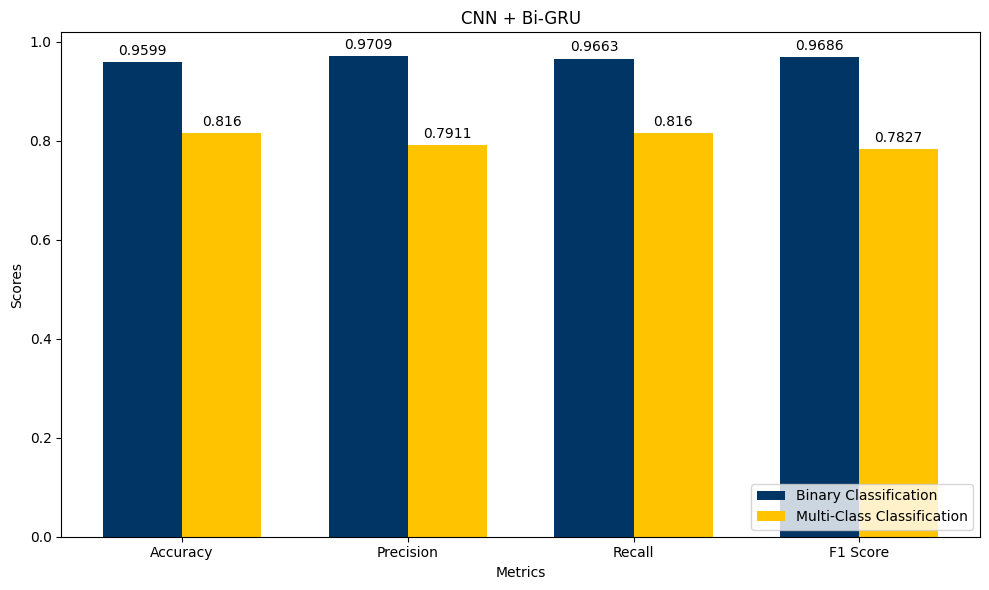

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + Bi-GRU')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

CNN + LSTM 02

In [ ]:
# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# LSTM for sequence modeling
x = LSTM(50, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)

# Shared Dense layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
model02LSTM_P = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

In [ ]:
# Compile the model
model02LSTM_P.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)


In [ ]:
# Train the model
model02LSTM_P.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=5, batch_size=32, validation_split=0.2
)

Epoch 1/5
5154/5154 [==============================] - 122s 23ms/step - loss: 1.1303 - binary_output_loss: 0.2665 - multi_class_output_loss: 0.8639 - binary_output_accuracy: 0.8745 - multi_class_output_accuracy: 0.6839 - val_loss: 0.8829 - val_binary_output_loss: 0.1838 - val_multi_class_output_loss: 0.6992 - val_binary_output_accuracy: 0.9123 - val_multi_class_output_accuracy: 0.7320
Epoch 2/5
5154/5154 [==============================] - 100s 19ms/step - loss: 0.9010 - binary_output_loss: 0.1880 - multi_class_output_loss: 0.7130 - binary_output_accuracy: 0.9081 - multi_class_output_accuracy: 0.7311 - val_loss: 0.7995 - val_binary_output_loss: 0.1576 - val_multi_class_output_loss: 0.6419 - val_binary_output_accuracy: 0.9208 - val_multi_class_output_accuracy: 0.7537
Epoch 3/5
5154/5154 [==============================] - 109s 21ms/step - loss: 0.8284 - binary_output_loss: 0.1676 - multi_class_output_loss: 0.6609 - binary_output_accuracy: 0.9169 - multi_class_output_accuracy: 0.7541 - val

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = model02LSTM_P.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}


1611/1611 [==============================] - 9s 5ms/step
Binary Classification:
Accuracy: 0.9367614242747647
Precision: 0.9646896638155215
Recall: 0.9352408723649839
F1 Score: 0.9497370409784235
Confusion Matrix:
[[17486  1127]
 [ 2132 30790]]

Multi-Class Classification:
Accuracy: 0.7854467837392064
Precision: 0.728303831347416
Recall: 0.7854467837392064
F1 Score: 0.746030525626731
Confusion Matrix:
[[    0     0     0   419     8     0    74    18     0     0]
 [    0     0     0   414     6     0    16    32     0     0]
 [    0     0     0  2917    68    13    76   218     0     0]
 [    0     0     0  7876   231     8   378   587     0     0]
 [    0     0     6   710  1761     0  2128   226     0     0]
 [    0     0     0   195    45 11230    33    34     0     0]
 [    0     0     0   177   383     1 17927   125     0     0]
 [    0     0     0   887    57     2   222  1684     0     0]
 [    0     0     0    29    25     0    58   197     0     0]
 [    0     0     0    31    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


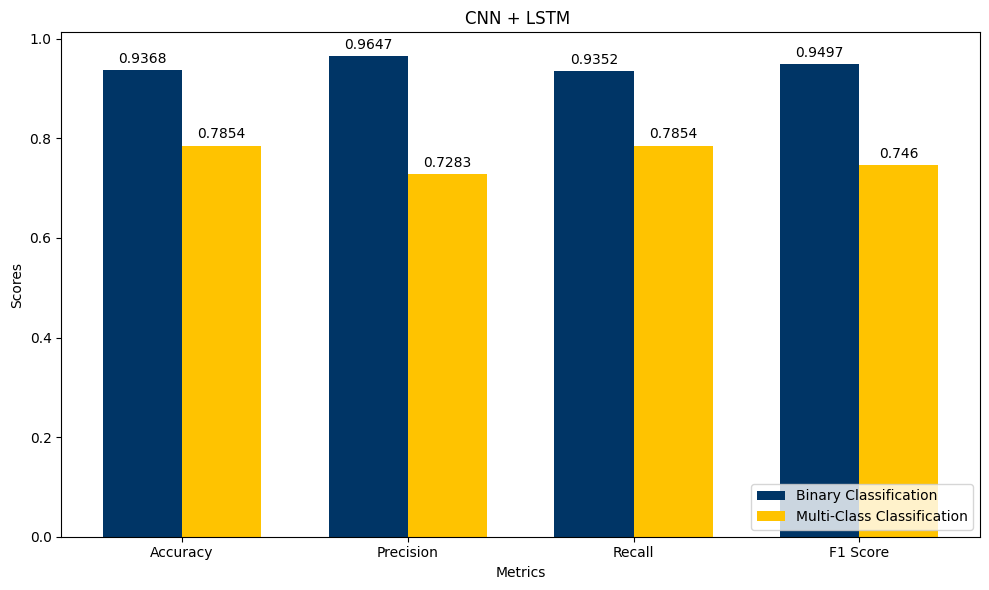

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + LSTM ')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

CNN + Bi-LSTM 02

In [ ]:
# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.01)(x)

# LSTM for sequence modeling
x = LSTM(50, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)

# Shared Dense layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.01)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
model02BiLSTM_P = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

In [ ]:
# Compile the model
model02BiLSTM_P.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)

In [ ]:
# Train the model
model02BiLSTM_P.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=10, batch_size=32, validation_split=0.2
)


Epoch 1/10
5154/5154 [==============================] - 102s 19ms/step - loss: 0.9653 - binary_output_loss: 0.2093 - multi_class_output_loss: 0.7561 - binary_output_accuracy: 0.8950 - multi_class_output_accuracy: 0.7216 - val_loss: 0.7800 - val_binary_output_loss: 0.1587 - val_multi_class_output_loss: 0.6212 - val_binary_output_accuracy: 0.9231 - val_multi_class_output_accuracy: 0.7679
Epoch 2/10
5154/5154 [==============================] - 96s 19ms/step - loss: 0.7450 - binary_output_loss: 0.1473 - multi_class_output_loss: 0.5977 - binary_output_accuracy: 0.9271 - multi_class_output_accuracy: 0.7753 - val_loss: 0.6948 - val_binary_output_loss: 0.1364 - val_multi_class_output_loss: 0.5584 - val_binary_output_accuracy: 0.9375 - val_multi_class_output_accuracy: 0.7912
Epoch 3/10
5154/5154 [==============================] - 97s 19ms/step - loss: 0.6615 - binary_output_loss: 0.1219 - multi_class_output_loss: 0.5396 - binary_output_accuracy: 0.9458 - multi_class_output_accuracy: 0.8004 - va

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = model02BiLSTM_P.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}


1611/1611 [==============================] - 10s 6ms/step
Binary Classification:
Accuracy: 0.9633841078878432
Precision: 0.9883556254917388
Recall: 0.9539213899520078
F1 Score: 0.9708332689305533
Confusion Matrix:
[[18243   370]
 [ 1517 31405]]

Multi-Class Classification:
Accuracy: 0.8337634617250412
Precision: 0.8224454063186228
Recall: 0.8337634617250412
F1 Score: 0.8158920424845819
Confusion Matrix:
[[   31     3    41   313    54     0    77     0     0     0]
 [    0     1    34   333    74     0    10    12     4     0]
 [    2     0   586  2478    96     1    72    37    20     0]
 [   14     0   513  7852   396     5   205    61    34     0]
 [    3     0    64   484  3035     0  1158    74    13     0]
 [    0     0    58   174    35 11226    31    10     2     1]
 [    2     0     1    56   206     0 18296    44     8     0]
 [    0     0    72   764    75     1   103  1835     2     0]
 [    0     0     3    63    47     0    42    51   103     0]
 [    0     0     0    28 

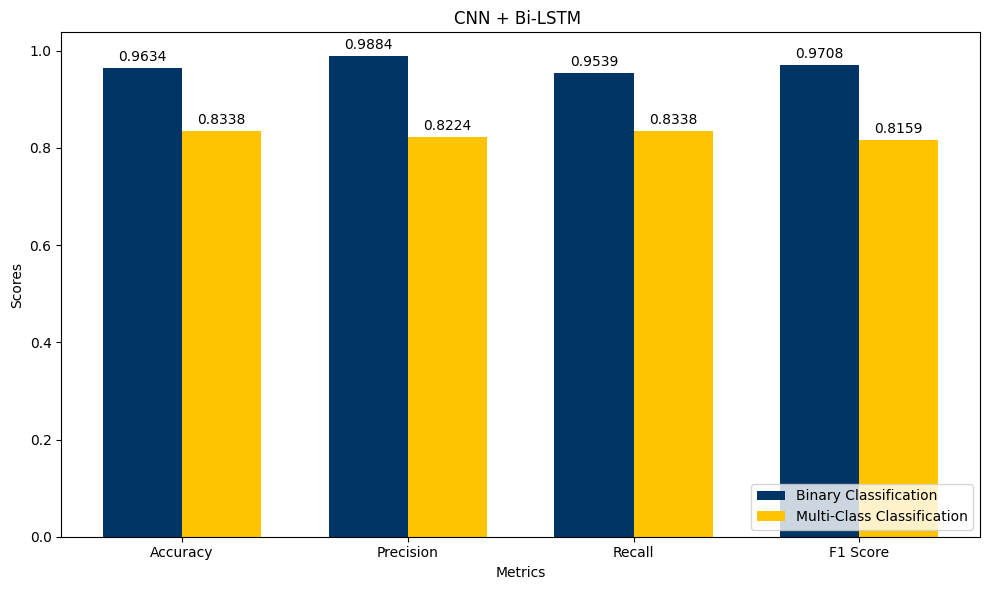

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + Bi-LSTM ')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

CNN + Bi-LSTM 03

In [ ]:
# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# LSTM for sequence modeling
x = LSTM(50, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)

# Shared Dense layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(y_multi_class.unique()), activation='softmax', name='multi_class_output')(x)

# Define the model
model02BiLSTM_P = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

In [ ]:
# Compile the model
model02BiLSTM_P.compile(
    optimizer='adam',
    loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
    metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'}
)

In [ ]:
# Train the model
model02BiLSTM_P.fit(
    X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
    epochs=8, batch_size=32, validation_split=0.2
)


Epoch 1/8
5154/5154 [==============================] - 89s 17ms/step - loss: 1.1062 - binary_output_loss: 0.2561 - multi_class_output_loss: 0.8501 - binary_output_accuracy: 0.8784 - multi_class_output_accuracy: 0.6884 - val_loss: 0.8673 - val_binary_output_loss: 0.1795 - val_multi_class_output_loss: 0.6878 - val_binary_output_accuracy: 0.9138 - val_multi_class_output_accuracy: 0.7407
Epoch 2/8
5154/5154 [==============================] - 83s 16ms/step - loss: 0.8729 - binary_output_loss: 0.1810 - multi_class_output_loss: 0.6919 - binary_output_accuracy: 0.9112 - multi_class_output_accuracy: 0.7449 - val_loss: 0.7752 - val_binary_output_loss: 0.1525 - val_multi_class_output_loss: 0.6227 - val_binary_output_accuracy: 0.9191 - val_multi_class_output_accuracy: 0.7686
Epoch 3/8
5154/5154 [==============================] - 85s 16ms/step - loss: 0.8131 - binary_output_loss: 0.1641 - multi_class_output_loss: 0.6490 - binary_output_accuracy: 0.9186 - multi_class_output_accuracy: 0.7616 - val_lo

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = model02BiLSTM_P.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')


# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}


1611/1611 [==============================] - 9s 5ms/step
Binary Classification:
Accuracy: 0.9457650140681091
Precision: 0.9605589017641484
Recall: 0.9542858878561449
F1 Score: 0.9574121196422314
Confusion Matrix:
[[17323  1290]
 [ 1505 31417]]

Multi-Class Classification:
Accuracy: 0.7984088483554865
Precision: 0.758224627878892
Recall: 0.7984088483554865
F1 Score: 0.7615805022281131
Confusion Matrix:
[[    0     0     0   425     4     0    81     9     0     0]
 [    0     0     1   419    18     0    16    14     0     0]
 [    0     0     2  3018    83     3    92    94     0     0]
 [    0     0     3  8271   344     5   302   155     0     0]
 [    0     0     0   743  2283     0  1737    68     0     0]
 [    0     0     2   218    51 11223    28    15     0     0]
 [    1     0     0   111   651     0 17799    51     0     0]
 [    0     0     0   921   154     0   209  1568     0     0]
 [    0     0     0    53    61     0    46   149     0     0]
 [    0     0     0    31   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


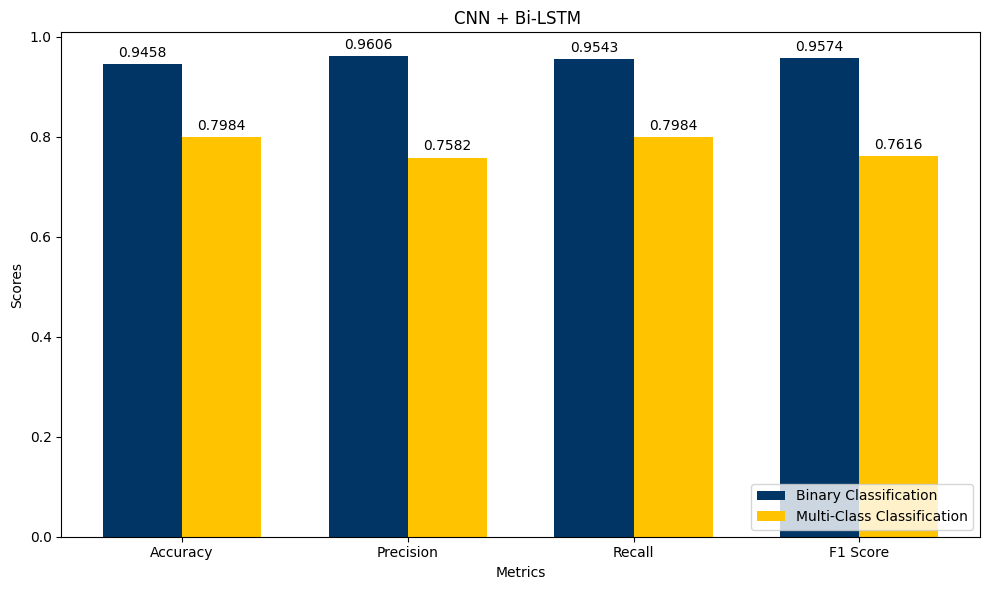

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + Bi-LSTM ')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()